# 1. Load the dataset

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("WELFake_Dataset.csv")

In [3]:
df.count()

Unnamed: 0    72134
title         71576
text          72095
label         72134
dtype: int64

In [4]:
print(df.head())

   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


In [5]:
df["title + text"] = df["title"] + ". " + df["text"]

### 1.1 Working on a subset of the dataset for initial testing

In [6]:
# # Working on a subset of the df for faster notebook runs
# subset_df = df.sample(n=10000, random_state=42)
# subset_df.to_csv('subset_WELFake.csv', index=False)

In [7]:
# df = pd.read_csv('subset_WELFake.csv')
# df.count()

# 2. FastText Embeddings

In [8]:
%pip install fasttext

Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import fasttext

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['title + text'], df['label'], test_size=0.2, random_state=42
)

### 2.1.1 Pretrained FastText Model

In [ ]:
# # Download the pretrained weights in the current working directory from here: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# model = fasttext.load_model('cc.en.300.bin')

### 2.1.2 Training our own FastText Model

In [ ]:
# X_train.to_csv("WELFake_train.csv", index=False)
# model = fasttext.train_unsupervised("WELFake_train.csv", model='skipgram')
# model.save_model("fast_text_model.bin")

In [ ]:
model = fasttext.load_model('fast_text_model.bin')

## 2.2 Generating embeddings using our choice of model

In [14]:
def get_sentence_embedding(text, model):
    if not isinstance(text, str):
        if pd.isna(text): # NaN -> ""
            text = ""
        else:
            text = str(text)
    clean_text = text.replace('\n', ' ').strip()
    try:
        return model.get_sentence_vector(clean_text)
    except ValueError as e:
        print(f"Error processing text: {clean_text[:50]}...")
        print(f"Error message: {e}")
        # Return a zero vector as fallback
        return np.zeros(model.get_dimension())

In [15]:
X_train_embeddings = np.array([get_sentence_embedding(text, model) for text in X_train])
X_test_embeddings = np.array([get_sentence_embedding(text, model) for text in X_test])

# 3. SVM

In [49]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
linear_svc = LinearSVC(dual=False)
calibrated_svc = CalibratedClassifierCV(linear_svc)
calibrated_svc.fit(X_train_embeddings, y_train)
y_pred = calibrated_svc.predict(X_test_embeddings)

In [51]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")

Accuracy: 0.9581

Classification Report:
              precision    recall  f1-score   support

           0     0.9566    0.9581    0.9574      7089
           1     0.9595    0.9580    0.9587      7338

    accuracy                         0.9581     14427
   macro avg     0.9580    0.9581    0.9581     14427
weighted avg     0.9581    0.9581    0.9581     14427

Matthews Correlation Coefficient: 0.9161077627249605


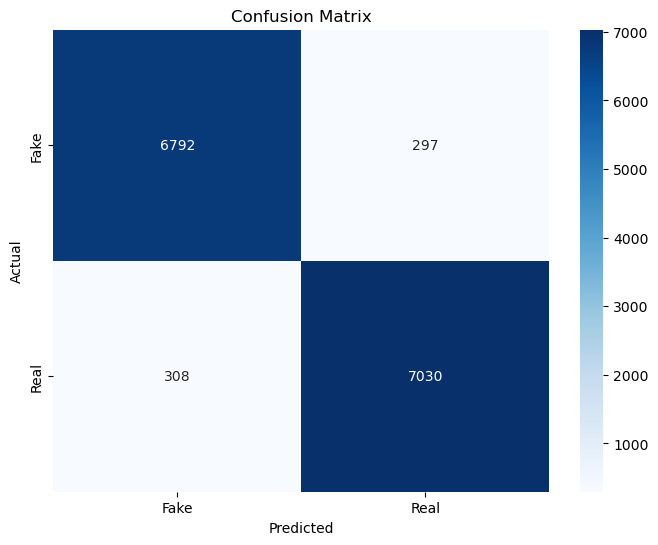

In [52]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4. XGBoost

In [53]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [54]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [55]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    early_stopping_rounds=10
)


In [56]:
xgb_model.fit(
    X_train_embeddings, 
    y_train,
    eval_set=[(X_test_embeddings, y_test)],
    verbose=True
)
y_pred = xgb_model.predict(X_test_embeddings)
y_prob = xgb_model.predict_proba(X_test_embeddings)[:, 1]


[0]	validation_0-logloss:0.63549
[1]	validation_0-logloss:0.58747
[2]	validation_0-logloss:0.54511
[3]	validation_0-logloss:0.50932
[4]	validation_0-logloss:0.47914
[5]	validation_0-logloss:0.45237
[6]	validation_0-logloss:0.42806
[7]	validation_0-logloss:0.40714
[8]	validation_0-logloss:0.38819
[9]	validation_0-logloss:0.37074
[10]	validation_0-logloss:0.35510
[11]	validation_0-logloss:0.34123
[12]	validation_0-logloss:0.32850
[13]	validation_0-logloss:0.31681
[14]	validation_0-logloss:0.30657
[15]	validation_0-logloss:0.29633
[16]	validation_0-logloss:0.28684
[17]	validation_0-logloss:0.27893
[18]	validation_0-logloss:0.27134
[19]	validation_0-logloss:0.26408
[20]	validation_0-logloss:0.25752
[21]	validation_0-logloss:0.25075
[22]	validation_0-logloss:0.24501
[23]	validation_0-logloss:0.23929
[24]	validation_0-logloss:0.23403
[25]	validation_0-logloss:0.22929
[26]	validation_0-logloss:0.22471
[27]	validation_0-logloss:0.22022


/opt/homebrew/Caskroom/miniconda/base/envs/DL/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [21:57:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[28]	validation_0-logloss:0.21606
[29]	validation_0-logloss:0.21246
[30]	validation_0-logloss:0.20826
[31]	validation_0-logloss:0.20489
[32]	validation_0-logloss:0.20133
[33]	validation_0-logloss:0.19793
[34]	validation_0-logloss:0.19521
[35]	validation_0-logloss:0.19242
[36]	validation_0-logloss:0.18938
[37]	validation_0-logloss:0.18652
[38]	validation_0-logloss:0.18403
[39]	validation_0-logloss:0.18194
[40]	validation_0-logloss:0.17994
[41]	validation_0-logloss:0.17750
[42]	validation_0-logloss:0.17568
[43]	validation_0-logloss:0.17337
[44]	validation_0-logloss:0.17137
[45]	validation_0-logloss:0.16960
[46]	validation_0-logloss:0.16771
[47]	validation_0-logloss:0.16626
[48]	validation_0-logloss:0.16478
[49]	validation_0-logloss:0.16313
[50]	validation_0-logloss:0.16163
[51]	validation_0-logloss:0.16020
[52]	validation_0-logloss:0.15854
[53]	validation_0-logloss:0.15708
[54]	validation_0-logloss:0.15554
[55]	validation_0-logloss:0.15440
[56]	validation_0-logloss:0.15318
[57]	validatio

In [57]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc}")

Accuracy: 0.9558

Classification Report:
              precision    recall  f1-score   support

           0     0.9530    0.9573    0.9551      7089
           1     0.9585    0.9543    0.9564      7338

    accuracy                         0.9558     14427
   macro avg     0.9557    0.9558    0.9558     14427
weighted avg     0.9558    0.9558    0.9558     14427

Matthews Correlation Coefficient: 0.9115441180687233


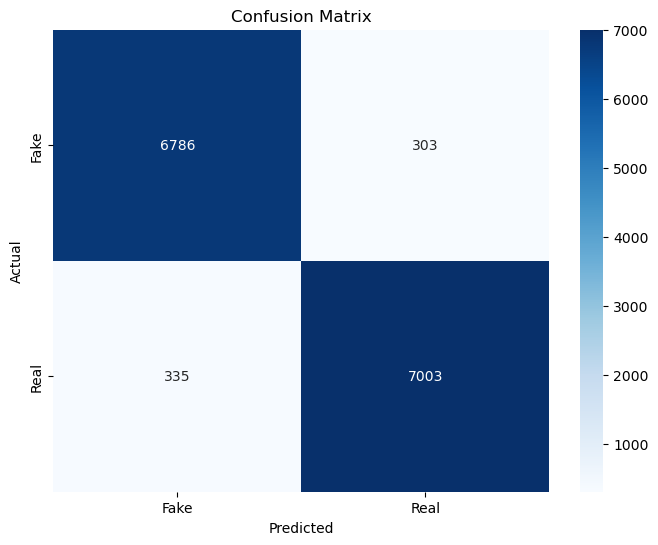

In [58]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], 
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. HAN

In [26]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
df_noNa = df.dropna()
df_han = pd.DataFrame({'text':df_noNa["title + text"].astype(str), 'label':df_noNa["label"]})

print(f"ORIGINAL TRAIN DATASET SIZE: {len(df_han)}")
# df_han = df_han.sample(10000, replace=False) # REDUCING SIZE FOR FASTER TRAINING/DEBUGGING
print(f"REDUCED TRAIN DATASET SIZE: {len(df_han)}")

ORIGINAL TRAIN DATASET SIZE: 71537
REDUCED TRAIN DATASET SIZE: 71537


In [27]:
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

print(device)

mps


In [28]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nltk
nLTK_DOWNLOAD_DIR = "./NLTK"
nltk.download('punkt', download_dir=nLTK_DOWNLOAD_DIR)
nltk.download('punkt_tab', download_dir=nLTK_DOWNLOAD_DIR)
nltk.data.path.append(nLTK_DOWNLOAD_DIR)

from torch.utils.data import DataLoader, TensorDataset, random_split
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')

MAX_SENTENCES = 20  # Max sentences per document
MAX_WORDS = 20     # Max words per sentence
BATCH_SIZE = 16

all_words = []
for text in df_han['text']:
    sentences = sent_tokenize(text)
    for sent in sentences:
        all_words.extend(word_tokenize(sent))
        
word2idx = {word: idx+1 for idx, word in enumerate(set(all_words))}
word2idx["<PAD>"] = 0

processed_texts = []
for text in df_han['text']:
    sentences = sent_tokenize(text)[:MAX_SENTENCES]
    
    sentence_indices = []
    for sent in sentences:
        words = word_tokenize(sent)[:MAX_WORDS]
        indices = [word2idx.get(word, 0) for word in words]
        
        if len(indices) < MAX_WORDS:
            indices += [0] * (MAX_WORDS - len(indices))
        else:
            indices = indices[:MAX_WORDS]
            
        sentence_indices.append(indices)
    
    if len(sentence_indices) < MAX_SENTENCES:
        pad = [[0]*MAX_WORDS] * (MAX_SENTENCES - len(sentence_indices))
        sentence_indices += pad
    else:
        sentence_indices = sentence_indices[:MAX_SENTENCES]
    
    processed_texts.append(sentence_indices)

text_tensor = torch.LongTensor(processed_texts).to(device)
label_tensor = torch.FloatTensor(df_han['label'].values).to(device)

[nltk_data] Downloading package punkt to ./NLTK...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to ./NLTK...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /Users/noobrobot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
dataset = TensorDataset(text_tensor, label_tensor)
train, test = random_split(dataset, [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)])
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HierarchicalAttentionNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        
        # WORD
        self.word_embed = nn.Embedding(vocab_size, embed_dim)
        self.word_gru = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
        self.word_proj = nn.Linear(2*hidden_size, 2*hidden_size)
        self.word_ctx = nn.Linear(2*hidden_size, 1, bias=False)
        
        # SENTENCE
        self.sent_gru = nn.GRU(2*hidden_size, hidden_size, bidirectional=True, batch_first=True)
        self.sent_proj = nn.Linear(2*hidden_size, 2*hidden_size)
        self.sent_ctx = nn.Linear(2*hidden_size, 1, bias=False)
        
        self.classifier = nn.Linear(2*hidden_size, 1)

    def forward(self, x):
        batch_size, num_sent, num_word = x.size()
        
        # WORD LEVEL
        x = x.view(-1, num_word)
        emb = self.word_embed(x)
        
        word_out, _ = self.word_gru(emb)
        
        # WORD ATTENTION
        word_a = torch.tanh(self.word_proj(word_out))
        word_attn = F.softmax(self.word_ctx(word_a).squeeze(-1), dim=1)
        sentence_vec = torch.bmm(word_out.transpose(1,2), word_attn.unsqueeze(2)).squeeze(2)
        
        # SENTENCE LEVEL
        sentence_vec = sentence_vec.view(batch_size, num_sent, -1) 
        sent_out, _ = self.sent_gru(sentence_vec)
        
        # SENTENCE ATTENTION
        sent_a = torch.tanh(self.sent_proj(sent_out))
        sent_attn = F.softmax(self.sent_ctx(sent_a).squeeze(-1), dim=1)
        document_vec = torch.bmm(sent_out.transpose(1,2), sent_attn.unsqueeze(2)).squeeze(2)
        
        return torch.sigmoid(self.classifier(document_vec).squeeze(1))


In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.03
EPOCHS = 30
VOCAB_SIZE = len(word2idx)
embed_dim = 200    
hidden_size = 50    

model = HierarchicalAttentionNetwork(VOCAB_SIZE, embed_dim, hidden_size).to(device)

criterion = nn.BCELoss()

optimizer = torch.optim.Adadelta(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(EPOCHS):
    totloss = 0
    for batch in train_loader:
        texts, labels = batch
        texts = texts.to(device)
        labels = labels.to(device)
        probs = model(texts)
        loss = criterion(probs, labels.float())
        totloss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(totloss/len(train_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {losses[-1]:.4f}")



Epoch 1/30, Loss: 0.5006
Epoch 2/30, Loss: 0.1315
Epoch 3/30, Loss: 0.0850
Epoch 4/30, Loss: 0.0672
Epoch 5/30, Loss: 0.0568
Epoch 6/30, Loss: 0.0483
Epoch 7/30, Loss: 0.0420
Epoch 8/30, Loss: 0.0361
Epoch 9/30, Loss: 0.0316
Epoch 10/30, Loss: 0.0270
Epoch 11/30, Loss: 0.0231
Epoch 12/30, Loss: 0.0198
Epoch 13/30, Loss: 0.0169
Epoch 14/30, Loss: 0.0142
Epoch 15/30, Loss: 0.0118
Epoch 16/30, Loss: 0.0097
Epoch 17/30, Loss: 0.0081
Epoch 18/30, Loss: 0.0069
Epoch 19/30, Loss: 0.0052
Epoch 20/30, Loss: 0.0045
Epoch 21/30, Loss: 0.0035
Epoch 22/30, Loss: 0.0030
Epoch 23/30, Loss: 0.0026
Epoch 24/30, Loss: 0.0021
Epoch 25/30, Loss: 0.0018
Epoch 26/30, Loss: 0.0017
Epoch 27/30, Loss: 0.0016
Epoch 28/30, Loss: 0.0014
Epoch 29/30, Loss: 0.0013
Epoch 30/30, Loss: 0.0013


In [33]:
torch.save(model, "H3_mps.pt") 
torch.save(model.to("cpu"), "H3_cpu.pt")

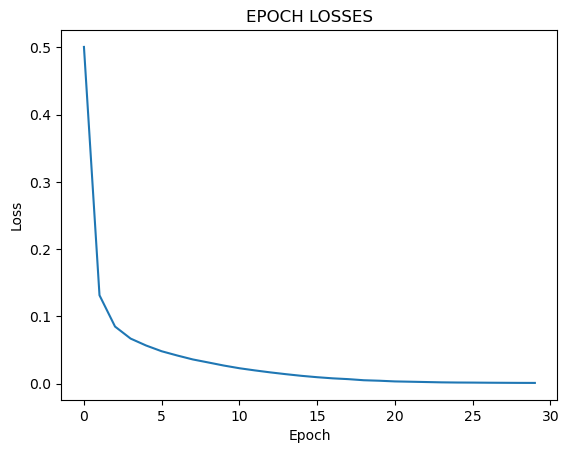

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(losses)
plt.title("EPOCH LOSSES")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [35]:
model = torch.load("H3_mps.pt")
# device = torch.device("cpu")

In [36]:
model.eval()

test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        texts, labels = batch
        texts = texts.to(device)
        labels = labels.to(device)
        probs = model(texts)
        predictions.extend(probs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

model.train()

HierarchicalAttentionNetwork(
  (word_embed): Embedding(449525, 200)
  (word_gru): GRU(200, 50, batch_first=True, bidirectional=True)
  (word_proj): Linear(in_features=100, out_features=100, bias=True)
  (word_ctx): Linear(in_features=100, out_features=1, bias=False)
  (sent_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (sent_proj): Linear(in_features=100, out_features=100, bias=True)
  (sent_ctx): Linear(in_features=100, out_features=1, bias=False)
  (classifier): Linear(in_features=100, out_features=1, bias=True)
)

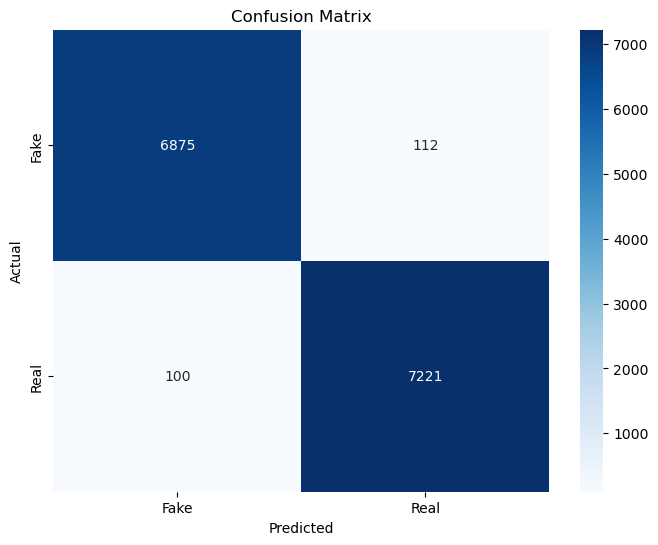

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef
import seaborn as sns

cm = confusion_matrix(true_labels, np.round(predictions))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [39]:
accuracy = accuracy_score(true_labels, np.round(predictions))
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, np.round(predictions), digits=4))
mcc = matthews_corrcoef(true_labels, np.round(predictions))
print(f"Matthews Correlation Coefficient: {mcc}")

Accuracy: 0.9852

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9857    0.9840    0.9848      6987
         1.0     0.9847    0.9863    0.9855      7321

    accuracy                         0.9852     14308
   macro avg     0.9852    0.9852    0.9852     14308
weighted avg     0.9852    0.9852    0.9852     14308

Matthews Correlation Coefficient: 0.9703502767956756
